In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'fecb24e7bb234d45aab31258e64a6753')

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [5]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)

150

In [7]:
doc(os.environ.get)

In [6]:
bear_types = 'grizzly','black','teddy'
path = Path('bears') #must be defined as a path item

In [7]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [8]:
fns = get_image_files(path)
fns

(#435) [Path('bears/grizzly/00000047.jpg'),Path('bears/grizzly/00000055.jpg'),Path('bears/grizzly/00000107.jpg'),Path('bears/grizzly/00000036.jpg'),Path('bears/grizzly/00000030.jpg'),Path('bears/grizzly/00000097.jpg'),Path('bears/grizzly/00000148.jpg'),Path('bears/grizzly/00000029.jpg'),Path('bears/grizzly/00000112.jpg'),Path('bears/grizzly/00000091.jpg')...]

In [9]:
failed = verify_images(fns)
failed
len(failed)

0

In [10]:
failed.map(Path.unlink);

In [11]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [12]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

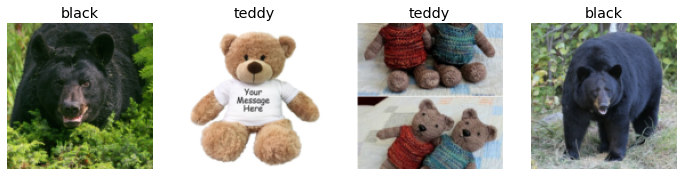

In [13]:
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

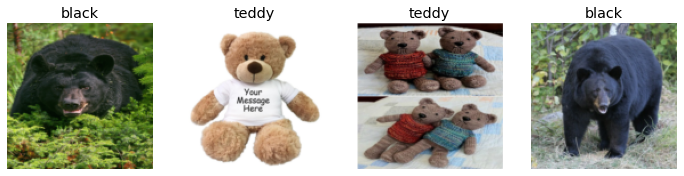

In [14]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

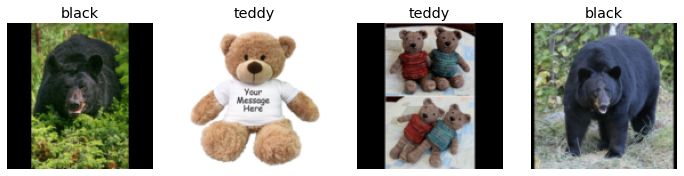

In [15]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

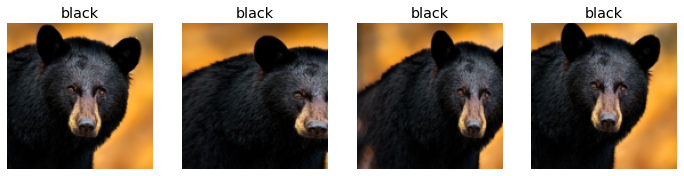

In [16]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

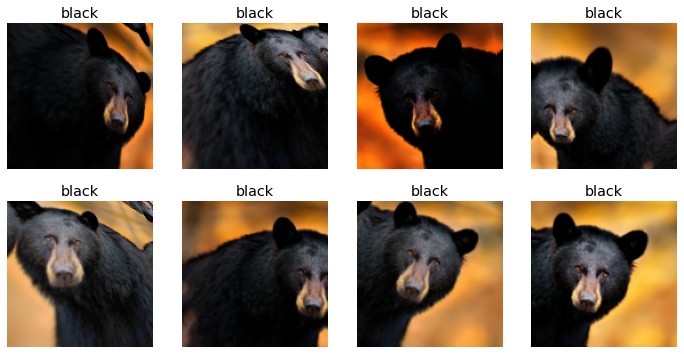

In [17]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [18]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [19]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.376228,0.052313,0.011494,00:13


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.205595,0.030838,0.022989,00:12
1,0.128071,0.034989,0.011494,00:12
2,0.089965,0.050426,0.011494,00:12
3,0.075325,0.048475,0.011494,00:12


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


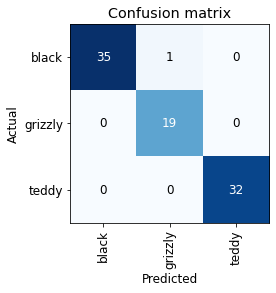

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

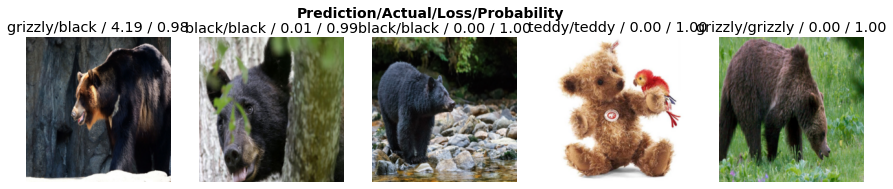

In [21]:
interp.plot_top_losses(5, nrows=1)

In [22]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
learn.export()

In [6]:
path = Path() #initialize empty path object
path.ls(file_exts='.pkl') #the ls method verifies this path

(#2) [Path('export.pkl'),Path('export-bp.pkl')]

In [7]:
learn_inf = load_learner(path/'export.pkl')

In [8]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']
dest = 'grizzly.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

learn_inf.predict('grizzly.jpg')


('grizzly', TensorImage(1), TensorImage([6.3086e-06, 9.9999e-01, 2.3958e-07]))

In [41]:
# list the categories of the dependent variable
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [9]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [11]:
img = PILImage.create(btn_upload.data[-1])

In [12]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [14]:
learn_inf.predict(img)
pred,pred_idx,probs = learn_inf.predict(img) #need this syntax to define an array output into multiple objects

In [15]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}' 
    # f' seems to preface text
    # probs is like a function which we can assign the predicted class index to
    #.04 is decimal places behind coma 
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [16]:
probs[0]

TensorImage(6.3086e-06)

In [17]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [18]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)


In [19]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [20]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [2]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila
!--use-feature=2020-resolver #from error message if only above line is run

Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.7 OK
/bin/bash: --: invalid option
Usage:	/bin/bash [GNU long option] [option] ...
	/bin/bash [GNU long option] [option] script-file ...
GNU long options:
	--debug
	--debugger
	--dump-po-strings
	--dump-strings
	--help
	--init-file
	--login
	--noediting
	--noprofile
	--norc
	--posix
	--rcfile
	--restricted
	--verbose
	--version
Shell options:
	-ilrsD or -c command or -O shopt_option		(invocation only)
	-abefhkmnptuvxBCHP or -o option


In [ ]:
##########################################
##################TRIALS##################
##########################################

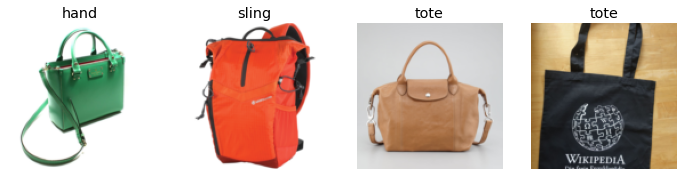

In [22]:
#download images for 3 types of bags
bag_types = 'hand','tote','sling'
path = Path('bags')
if not path.exists():
    path.mkdir()
    for o in bag_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bag')
        download_images(dest, urls=results.attrgot('contentUrl'))
        
#store in object
fns = get_image_files(path)
failed = verify_images(fns)
failed
len(failed)

#unlink unverified
failed.map(Path.unlink);

#initialize datablock
bags = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

#set bags as dataloaders item
dls = bags.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

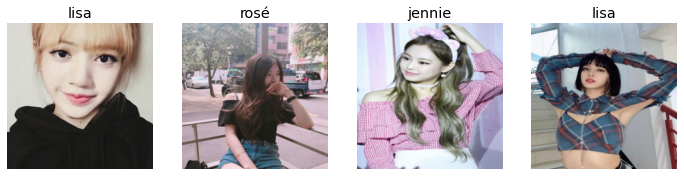

In [4]:
#download images for 3 types of bags
bp_types = 'lisa','jennie','rosé','jisoo'
path = Path('bp')
if not path.exists():
    path.mkdir()
    for o in bp_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bp')
        download_images(dest, urls=results.attrgot('contentUrl'))
        
#store in object
fns = get_image_files(path)
failed = verify_images(fns)
failed
len(failed)

#unlink unverified
failed.map(Path.unlink);

#initialize datablock
bp = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

#augment images
bp = bp.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

#set bags as dataloaders item
dls = bp.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)



In [5]:
#train model
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.628169,2.253568,0.733945,00:06


epoch,train_loss,valid_loss,error_rate,time
0,1.903949,1.621446,0.596330,00:08
1,1.759891,1.484939,0.504587,00:07
2,1.569515,1.410185,0.477064,00:08
3,1.453118,1.362982,0.431193,00:08


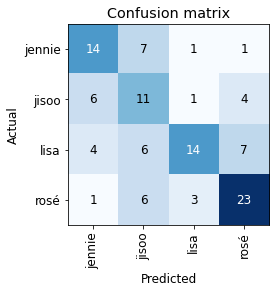

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [9]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [ ]:
#predict
learn.export()
path = Path()
path.ls(file_exts='.pkl')
learn_inf = load_learner(path/'export.pkl')

img = PILImage.create(uploader.data[0])

learn_inf.predict(img)


In [54]:
img = PILImage.create(uploader.data[0])
learn_inf.predict(img)


('jennie', TensorImage(0), TensorImage([0.7495, 0.1387, 0.1020, 0.0098]))

FileNotFoundError: [Errno 2] No such file or directory: '/storage/bags'